In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import sklearn as skl
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
def load_snp_csv(snp_file):
    df = pd.read_csv(snp_file)  # do NOT use index_col=0 here
    df.rename(columns={df.columns[0]: 'GID'}, inplace=True)  # First column is GID
    df = df.astype(float, errors='ignore')  # Only SNPs will be float
    return df

class MultiModalDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, image_path, geno_feature_cols, batch_size=32, shuffle=True):
        self.df = dataframe.reset_index(drop=True)
        self.image_path = image_path
        self.geno_feature_cols = geno_feature_cols
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_df = self.df.iloc[index * self.batch_size : (index + 1) * self.batch_size]
        
        X_img = []
        X_geno = []
        Y = []
        
        for _, row in batch_df.iterrows():
            # Load image
            img = np.load(os.path.join(self.image_path, row['Filename']))
            X_img.append(img)

            # Genomic features
            geno = row[self.geno_feature_cols].values.astype(np.float32)
            X_geno.append(geno)

            # Yield
            Y.append(row['GRYLD'])

        return [np.array(X_img), np.array(X_geno)], np.array(Y)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [3]:
geno_df = load_snp_csv("SNPs_phased_reduced.csv")

In [4]:
csv_path = "/scratch/pawsey1157/rtrivedi/dataset/Phenotypes/Images_GIDs_GRYLD.csv"
img_df = pd.read_csv(csv_path, header=None, names=['Filename', 'GID', 'GRYLD'])

In [5]:
from sklearn.model_selection import train_test_split

# Load data
#geno_df = pd.read_csv('SNPs_phased_reduced.csv')
#img_df = pd.read_csv('Images_GIDs_GRYLD.csv')

# Reset index to make GID a column again
#geno_df_reset = geno_df.reset_index()

merged_df = pd.merge(img_df, geno_df, on='GID')

# Drop any NaNs
merged_df = merged_df.dropna(subset=['GRYLD'])

# Define genomic columns
geno_feature_cols = [col for col in merged_df.columns if col not in ['GID', 'Filename', 'GRYLD']]

image_path = "/scratch/pawsey1157/rtrivedi/dataset/Phenotypes/stacked_npy/"

#train_df, val_df = train_test_split(merged_df, test_size=0.2, random_state=42)

# Extract unique GIDs
unique_gids = merged_df['GID'].unique()

# Train/test split on GIDs
train_gids, val_gids = train_test_split(unique_gids, test_size=0.3, random_state=42)

# Subset the full dataframe based on GIDs
train_df = merged_df[merged_df['GID'].isin(train_gids)].reset_index(drop=True)
val_df = merged_df[merged_df['GID'].isin(val_gids)].reset_index(drop=True)

# Create generator
train_gen = MultiModalDataGenerator(
    dataframe=train_df,
    image_path=image_path,
    geno_feature_cols=geno_feature_cols,
    batch_size=32,
    shuffle=True
)

val_gen = MultiModalDataGenerator(
    dataframe=val_df,
    image_path=image_path,
    geno_feature_cols=geno_feature_cols,
    batch_size=32,
    shuffle=False  # don't shuffle validation
)

In [9]:
# Alignment check

# Display a few rows to check alignment
sample = merged_df.sample(1).iloc[0]
print(f"GID: {sample['GID']}")
print(f"Filename: {sample['Filename']}")
print(f"Yield (GRYLD): {sample['GRYLD']:.3f}")

# Check genotype vector
geno_vector = sample[geno_feature_cols].values
print(f"Genotype shape: {geno_vector.shape}")
print(f"Non-zero SNPs: {(geno_vector != 0).sum()}, Mean: {geno_vector.mean():.4f}")

GID: GID8248483
Filename: 18-OBR-YTBW-B5I-29804-20180321_210230_IMG_0729_1.npy
Yield (GRYLD): 7.650
Genotype shape: (84322,)
Non-zero SNPs: 12236, Mean: 0.1364


In [6]:
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate

# Load and rename image model
image_model = load_model('CNN.h5', compile=False)
image_model._name = 'image_model'  # Rename to avoid name clash

# Load and rename genotype model
geno_model = load_model('wheat_height_predictor.h5', compile=False)
geno_model._name = 'geno_model'  # Rename to avoid name clash

# Freeze both models
for layer in image_model.layers:
    layer.trainable = False
for layer in geno_model.layers:
    layer.trainable = False

# Define new inputs
img_input = Input(shape=image_model.input_shape[1:], name='image_input')
geno_input = Input(shape=geno_model.input_shape[1:], name='geno_input')

# Pass through models
img_features = image_model(img_input)
geno_features = geno_model(geno_input)

# Combine
fusion = concatenate([img_features, geno_features], name='fusion')
x = layers.Dense(128, activation='relu', name='fusion_dense_1')(fusion)
x = layers.Dropout(0.3, name='fusion_dropout_1')(x)
x = layers.Dense(64, activation='relu', name='fusion_dense_2')(x)
x = layers.Dropout(0.2, name='fusion_dropout_2')(x)
output = layers.Dense(1, activation='relu', name='yield_output')(x)   # setting this to 2 makes the model produce two outputs - incompatible with downstream analysis

# Final model
fusion_model = Model(inputs=[img_input, geno_input], outputs=output)
fusion_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [7]:
#mini model

history = fusion_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    steps_per_epoch=100,        
    validation_steps=40,      
    verbose=1
)

Epoch 1/10
100/100 [==============================] - 144s 1s/step - loss: 7.1325 - mae: 1.8956 - val_loss: 0.4945 - val_mae: 0.5934
Epoch 2/10
100/100 [==============================] - 141s 1s/step - loss: 1.4453 - mae: 0.9611 - val_loss: 0.4061 - val_mae: 0.5420
Epoch 3/10
100/100 [==============================] - 138s 1s/step - loss: 1.1216 - mae: 0.8393 - val_loss: 1.2920 - val_mae: 1.0816
Epoch 4/10
100/100 [==============================] - 139s 1s/step - loss: 1.0245 - mae: 0.8076 - val_loss: 0.7104 - val_mae: 0.7726
Epoch 5/10
100/100 [==============================] - 139s 1s/step - loss: 0.9058 - mae: 0.7580 - val_loss: 0.5742 - val_mae: 0.6810
Epoch 6/10
100/100 [==============================] - 139s 1s/step - loss: 0.8997 - mae: 0.7567 - val_loss: 0.5118 - val_mae: 0.6357
Epoch 7/10
100/100 [==============================] - 138s 1s/step - loss: 0.8660 - mae: 0.7377 - val_loss: 0.5510 - val_mae: 0.6647
Epoch 8/10
100/100 [==============================] - 138s 1s/step - 

In [8]:
history = fusion_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,         
    verbose=1
)

Epoch 1/20
3831/3831 [==============================] - 5050s 1s/step - loss: 0.7795 - mae: 0.6761 - val_loss: 0.1312 - val_mae: 0.2653
Epoch 2/20
3831/3831 [==============================] - 4962s 1s/step - loss: 0.3822 - mae: 0.4865 - val_loss: 0.1177 - val_mae: 0.2529
Epoch 3/20
3831/3831 [==============================] - 4860s 1s/step - loss: 0.3084 - mae: 0.4337 - val_loss: 0.1039 - val_mae: 0.2287
Epoch 4/20
3831/3831 [==============================] - 4932s 1s/step - loss: 0.2532 - mae: 0.3908 - val_loss: 0.0977 - val_mae: 0.2204
Epoch 5/20
3831/3831 [==============================] - 5017s 1s/step - loss: 0.2099 - mae: 0.3541 - val_loss: 0.0997 - val_mae: 0.2262
Epoch 6/20
3831/3831 [==============================] - 5286s 1s/step - loss: 0.1788 - mae: 0.3241 - val_loss: 0.0900 - val_mae: 0.2088
Epoch 7/20
3831/3831 [==============================] - 5127s 1s/step - loss: 0.1601 - mae: 0.3050 - val_loss: 0.0944 - val_mae: 0.2145
Epoch 8/20
3831/3831 [==========================

KeyboardInterrupt: 

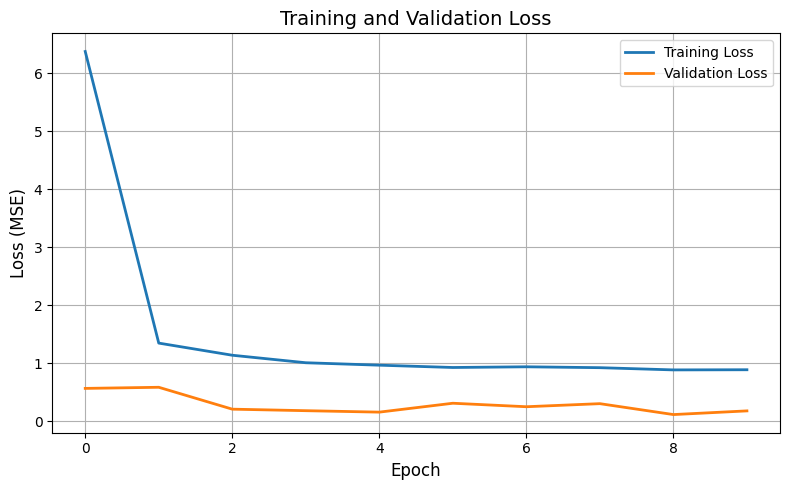

In [8]:
import matplotlib.pyplot as plt

# Assuming 'history' is the result from model.fit()
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# Disable shuffling in train_gen to make it deterministic
train_gen.shuffle = False
train_gen.on_epoch_end()  # Re-shuffle once manually if needed

# Predict on the whole generator
y_pred_train = fusion_model.predict(train_gen, verbose=1)

# Collect y_true **in sync**
y_true_train = []
for i in range(len(train_gen)):
    _, y = train_gen[i]
    y_true_train.append(y)
y_true_train = np.concatenate(y_true_train)

# Compute R²
from sklearn.metrics import r2_score
r2_train = r2_score(y_true_train, y_pred_train)
print(f"R² score (synced): {r2_train:.4f}")

3831/3831 [==============================] - 4237s 1s/step
R² score (synced): 0.8115


In [11]:
from sklearn.metrics import r2_score

y_pred_val = fusion_model.predict(val_gen)
y_true_val = np.concatenate([y for _, y in val_gen])

r2_val = r2_score(y_true_val, y_pred_val)
print(f"Validation R²: {r2_val:.4f}")

1554/1554 [==============================] - 1585s 1s/step
Validation R²: 0.7928


In [12]:
fusion_model.save('Multimodal.h5')

In [13]:
print("Predicted range:", y_pred_train.min(), "to", y_pred_train.max())
print("True range:", y_true_train.min(), "to", y_true_train.max())

Predicted range: 5.3653765 to 10.378135
True range: 3.977 to 10.055


In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.scatter(y_true_val, y_pred_val, alpha=0.4, edgecolors='k')
plt.plot([y_true_val.min(), y_true_val.max()],
         [y_true_val.min(), y_true_val.max()],
         'r--', linewidth=2)
plt.xlabel('True GRYLD')
plt.ylabel('Predicted GRYLD')
plt.title(f'Predicted vs True GRYLD\nValidation R² = {r2_val:.4f}')
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'y_true_val' is not defined

<Figure size 700x700 with 0 Axes>

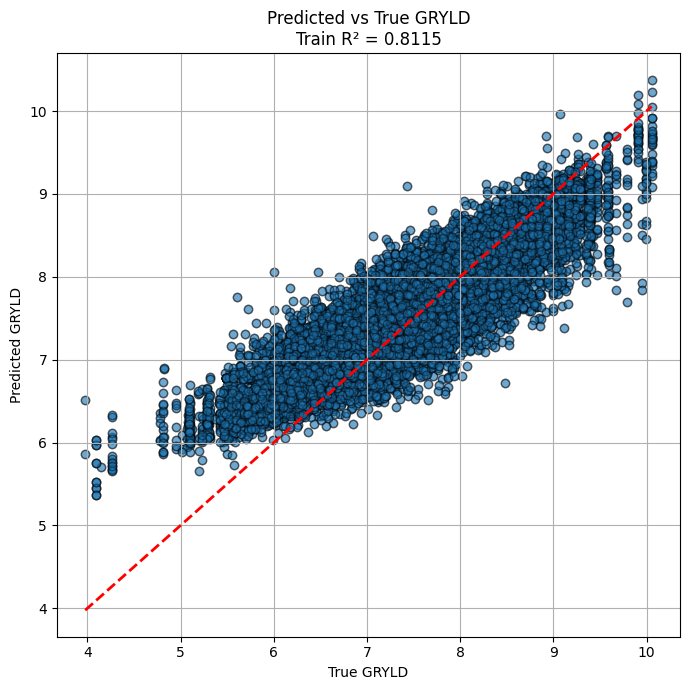

In [15]:
plt.figure(figsize=(7,7))
plt.scatter(y_true_train, y_pred_train, alpha=0.4, edgecolors='k')
plt.plot([y_true_train.min(), y_true_train.max()],
         [y_true_train.min(), y_true_train.max()],
         'r--', linewidth=2)
plt.xlabel('True GRYLD')
plt.ylabel('Predicted GRYLD')
plt.title(f'Predicted vs True GRYLD\nTrain R² = {r2_train:.4f}')
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
import shap
import numpy as np

# -----------------------
# Prepare background data
# -----------------------
# We can't take it from generators directly, so let's grab arrays from DataFrame
def get_data_from_df(df, image_path, geno_cols, max_samples=None):
    imgs = []
    genos = []
    for i, row in df.iterrows():
        if max_samples and i >= max_samples:
            break
        imgs.append(np.load(os.path.join(image_path, row['Filename'])))
        genos.append(row[geno_cols].values.astype(np.float32))
    return np.array(imgs), np.array(genos)

# Background: small random subset for speed
bg_imgs, bg_genos = get_data_from_df(train_df, image_path, geno_feature_cols, max_samples=10)

# Test samples: also small subset for demonstration
test_imgs, test_genos = get_data_from_df(val_df, image_path, geno_feature_cols, max_samples=2)

/software/projects/pawsey1157/rtrivedi/setonix/pythonEnvironments/tensorflowContainer_env/machinelearning/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# -----------------------
# Run SHAP
# -----------------------
explainer = shap.GradientExplainer(fusion_model, [bg_imgs, bg_genos])

# Get SHAP values for both inputs
shap_values = explainer.shap_values([test_imgs, test_genos])

# shap_values is a list: shap_values[0] → image input SHAPs, shap_values[1] → SNP input SHAPs
print("Image SHAP shape:", np.array(shap_values[0]).shape)
print("SNP SHAP shape:", np.array(shap_values[1]).shape)

/usr/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


Image SHAP shape: (2, 145, 61, 8, 1)
SNP SHAP shape: (2, 84322, 1)


/tmp/ipykernel_4068454/1787845098.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[1], test_genos, feature_names=geno_feature_cols)
/software/projects/pawsey1157/rtrivedi/setonix/pythonEnvironments/tensorflowContainer_env/machinelearning/lib/python3.10/site-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


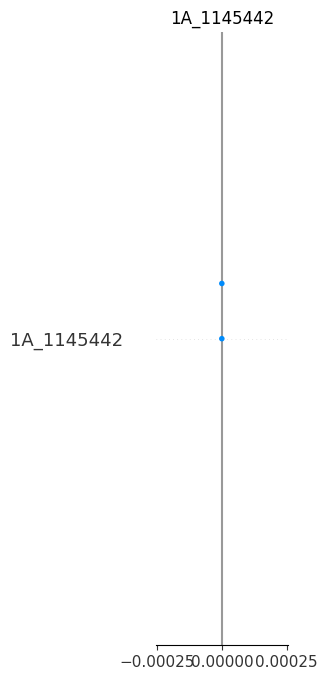

In [15]:
# -----------------------
# Plot SNP SHAP summary
# -----------------------
shap.summary_plot(shap_values[1], test_genos, feature_names=geno_feature_cols)


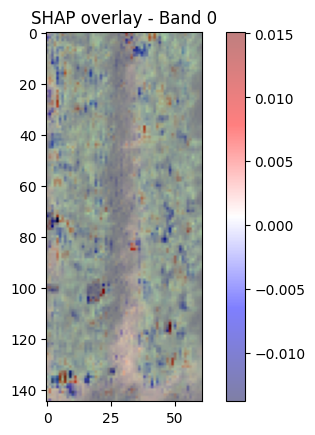

In [18]:
# -----------------------
# Plot an example image SHAP
# -----------------------

import matplotlib.pyplot as plt

idx = 0  # first sample
shap_img_vals = shap_values[0][idx]  # shape: (H, W, Bands)
plt.imshow(test_imgs[idx][:, :, :3])  # show RGB or subset
plt.imshow(shap_img_vals[:, :, 0], cmap='seismic', alpha=0.5)  # overlay for band 0
plt.colorbar()
plt.title("SHAP overlay - Band 0")
plt.show()

In [25]:
# Grab a subset from validation data
(X_imgs, X_snps), y_val = val_gen[0]  # or use several batches if needed

# Flatten each sample
X_imgs_flat = X_imgs.reshape((X_imgs.shape[0], -1))      # (n_samples, image_dims)
X_snps_flat = X_snps.reshape((X_snps.shape[0], -1))      # (n_samples, n_snps)

# Concatenate: now each row is a combined feature vector
X_combined = np.concatenate([X_imgs_flat, X_snps_flat], axis=1)

In [34]:
def fused_model_predict(X_combined):
    n_img_features = X_imgs_flat.shape[1]
    n_snp_features = X_snps.shape[1]

    print("X_combined shape:", X_combined.shape)

    # Sanity checks
    assert X_combined.shape[1] == n_img_features + n_snp_features, "Mismatched feature count!"

    X_img = X_combined[:, :n_img_features].reshape((-1, ) + X_imgs.shape[1:])
    X_snp = X_combined[:, n_img_features:]

    print("X_img shape:", X_img.shape)
    print("X_snp shape:", X_snp.shape)

    preds = fusion_model.predict([X_img, X_snp], verbose=0)

    print("Prediction shape:", preds.shape)

    return preds.reshape(-1, 1)

In [35]:
background = X_combined[:50]  # background data
test_samples = np.hstack([
    X_imgs_flat[:10],
    X_snps[:10]
])  # samples to explain

In [36]:
test_output = fused_model_predict(test_samples)
print(test_output[:5])

X_combined shape: (10, 155082)
X_img shape: (10, 145, 61, 8)
X_snp shape: (10, 84322)
Prediction shape: (10, 1)
[[7.7775917]
 [7.7775917]
 [7.674206 ]
 [7.674206 ]
 [7.3605785]]


In [37]:
import shap

explainer = shap.KernelExplainer(fused_model_predict, background)
shap_values = explainer.shap_values(test_samples)

X_combined shape: (32, 155082)
X_img shape: (32, 145, 61, 8)
X_snp shape: (32, 84322)
Prediction shape: (32, 1)


  0%|                                                                                                                                | 0/10 [00:05<?, ?it/s]

X_combined shape: (1, 155082)
X_img shape: (1, 145, 61, 8)
X_snp shape: (1, 84322)
Prediction shape: (1, 1)


MemoryError: Unable to allocate 3.40 TiB for an array with shape (188326, 4962624) and data type float32

In [32]:
print("test_samples shape:", test_samples.shape)


test_samples shape: (0, 155082)


In [33]:
n_img_features = X_imgs_flat.shape[1]  # e.g., 512 if your image was (16, 16, 2)
n_snp_features = X_snps.shape[1]       # e.g., 1000
print("Expected total features:", n_img_features + n_snp_features)

Expected total features: 155082
